In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import numpy as np
import h5py
import os 
print(os.path.exists('/wxw/lbs/SR/datasets/Urban_R162.mat'))

True


In [4]:
from scipy.io import loadmat

# 读取MAT文件
data = loadmat('/wxw/lbs/SR/datasets/Urban_R162.mat')
mat_data = torch.tensor(data['Y'] / data['Y'].max()).view(162,307,307)
c,h,w = mat_data.shape

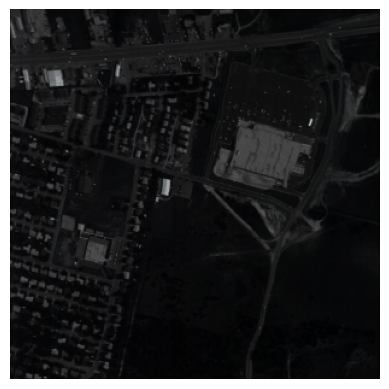

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mat_data[:3,:,:].permute(2,1,0).detach().cpu().numpy())
plt.axis('off')
plt.show()

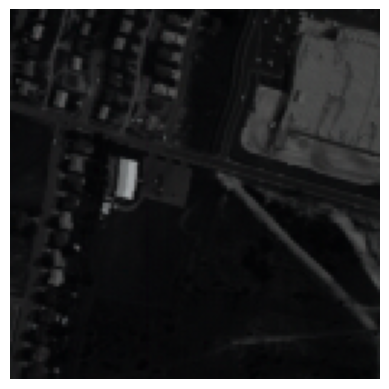

In [6]:
test_region = mat_data[:,h//2 -64: h//2 + 64,w // 2 -64: w // 2 + 64]
plt.imshow(test_region[:3,:,:].permute(2,1,0).detach().cpu().numpy())
plt.axis('off')
plt.show()

In [7]:
from einops import rearrange, repeat, einsum
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

class SpectralMixing(nn.Module):
    def __init__(self, hidden_feature=64):
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.layer_norm  = nn.LayerNorm(hidden_feature)
        
    def forward(self, x):   
        x = self.global_pool(x) * x
        x = x.permute(0,2,3,1)
        x = self.layer_norm(x)
        x = x.permute(0,3,1,2)
        return x

class SpectralGroupAttention(nn.Module):
    def __init__(self, channel=512,reduction=16,G=8):
        super().__init__()
        self.G=G
        self.channel=channel
        self.avg_pool = nn.AvgPool2d(1)
        self.spectral_weight = nn.Parameter(torch.ones(1, channel // (2 * G), 1, 1))
        self.spectral_bias = nn.Parameter(torch.ones(1, channel // (2 * G), 1, 1))
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(channel // (2 * G),1,3,1,1),
            nn.LeakyReLU(),
            nn.Conv2d(1,1,1),
            nn.LeakyReLU(),
            nn.Conv2d(1,1,3,1,1),
            nn.LeakyReLU(),
            nn.Conv2d(1,1,5,1,2)
        )
        

    @staticmethod
    def channel_shuffle(x, groups):
        b, c, h, w = x.shape
        x = x.reshape(b, groups, -1, h, w)
        x = x.permute(0, 2, 1, 3, 4)
        x = x.reshape(b, -1, h, w)
        return x
    
    def forward(self, x):
        b, c, h, w = x.size()
        x=x.view(b*self.G,-1,h,w) 
        x_0,x_1=x.chunk(2,dim=1)
        x_channel=self.avg_pool(x_0)                                 #bs*G,c//(2*G),1,1
        x_channel=self.spectral_weight*x_channel+self.spectral_bias                  #bs*G,c//(2*G),1,1
        x_channel=x_0*F.sigmoid(x_channel)
        #spatial attention
        x_spatial = self.spatial_conv(x_1)
        x_spatial = x_1 * x_spatial
        # concatenate along channel axis
        out = torch.cat([x_channel,x_spatial],dim=1)                   #bs*G,c//G,h,w
        out = out.contiguous().view(b,-1,h,w)
        return out
    
class SGANet(nn.Module):
    def __init__(self,bands,hidden_feature_dim,msi_band=3,group_num=2):
        super(SGANet, self).__init__()
        self.down_sample_conv = nn.Sequential(
            nn.Conv2d(msi_band,hidden_feature_dim,3,1,1),
            nn.ReLU(),
            nn.Conv2d(hidden_feature_dim,hidden_feature_dim,3,4,0),
            nn.ReLU()
        )
        self.up_conv = nn.Conv2d(bands + 3,hidden_feature_dim,3,1,1)
        self.down_conv = nn.Conv2d(hidden_feature_dim+bands,hidden_feature_dim*4*4,3,1,1)
        self.fuse_conv = nn.Conv2d(hidden_feature_dim * 2,hidden_feature_dim,3,1,1)
        self.se = SpectralGroupAttention(hidden_feature_dim,group_num)
        self.mainblocks = nn.Sequential(
            nn.Conv2d(hidden_feature_dim,hidden_feature_dim * 2,3,1,1),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_feature_dim * 2,hidden_feature_dim,3,1,1),
            nn.LeakyReLU()
        )
        self.refine = nn.Sequential(
            nn.Conv2d(hidden_feature_dim,hidden_feature_dim * 2,3,1,1),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_feature_dim * 2,bands,3,1,1)
        )

    def forward(self, hsi, msi):
        up_hsi = torch.nn.functional.interpolate(hsi,scale_factor=4) # [n,bands,64,64]
        down_msi = self.down_sample_conv(msi)                        # [n,hidden_feature_dim,64,64]
        up_hsi_msi = torch.concat([up_hsi,msi],dim=1)                # [n,bands + 3,64,64]
        down_msi_hsi = torch.concat([down_msi,hsi],dim=1)            # [n,hidden_feature_dim + bands,16,16]
        up_hsi_msi =   F.leaky_relu(self.up_conv(up_hsi_msi))             # [n,hidden_feature_dim,64,64]
        down_msi_hsi = F.leaky_relu(self.down_conv(down_msi_hsi))
        down_msi_hsi = F.pixel_shuffle(down_msi_hsi,4)                  # [n,hidden_feature_dim,64,64]
        main_feature = torch.concat([up_hsi_msi,up_hsi_msi],dim=1)
        main_feature = F.leaky_relu(self.fuse_conv(main_feature))       # [n,hidden_feature_dim,64,64]
        main_feature = self.se(main_feature)
        main_feature = self.mainblocks(main_feature) + main_feature
        main_feature = self.refine(main_feature)
        res = main_feature + up_hsi
        return res.clamp(0,1)

In [8]:
import torchvision
def downSamlpe(hsi):
    hsi_blur = torchvision.transforms.functional.gaussian_blur(hsi, kernel_size=3, sigma=0.5)
    down_hsi = F.interpolate(hsi.unsqueeze(0),scale_factor=1/4,mode='bilinear', align_corners=False)
    return down_hsi.squeeze(0).clamp(0,1)

/wxw/miniconda3/envs/lbs_env/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.24) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


(64, 162, 64, 64)


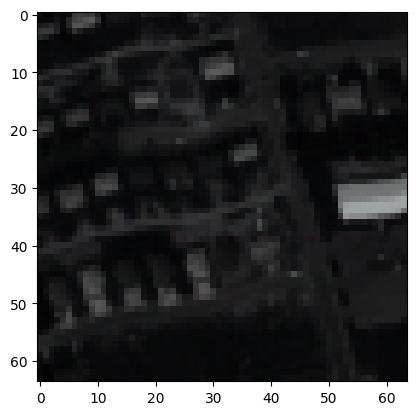

In [9]:
import numpy as np
loaded_data = np.load('/wxw/lbs/SR/HSR/datasets/Urban_test.npz')
gt = loaded_data['GT']
print(gt.shape)
plt.imshow(gt[8][:3].transpose(1,2,0))

/tmp/ipykernel_11415/2572893659.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_region = torch.tensor(test_region,dtype=torch.float32).cuda()


tensor(0.0356, device='cuda:0')
tensor(0.0283, device='cuda:0')
tensor(0.0183, device='cuda:0')
tensor(0.0159, device='cuda:0')
tensor(0.0121, device='cuda:0')
tensor(0.0060, device='cuda:0')
tensor(0., device='cuda:0')


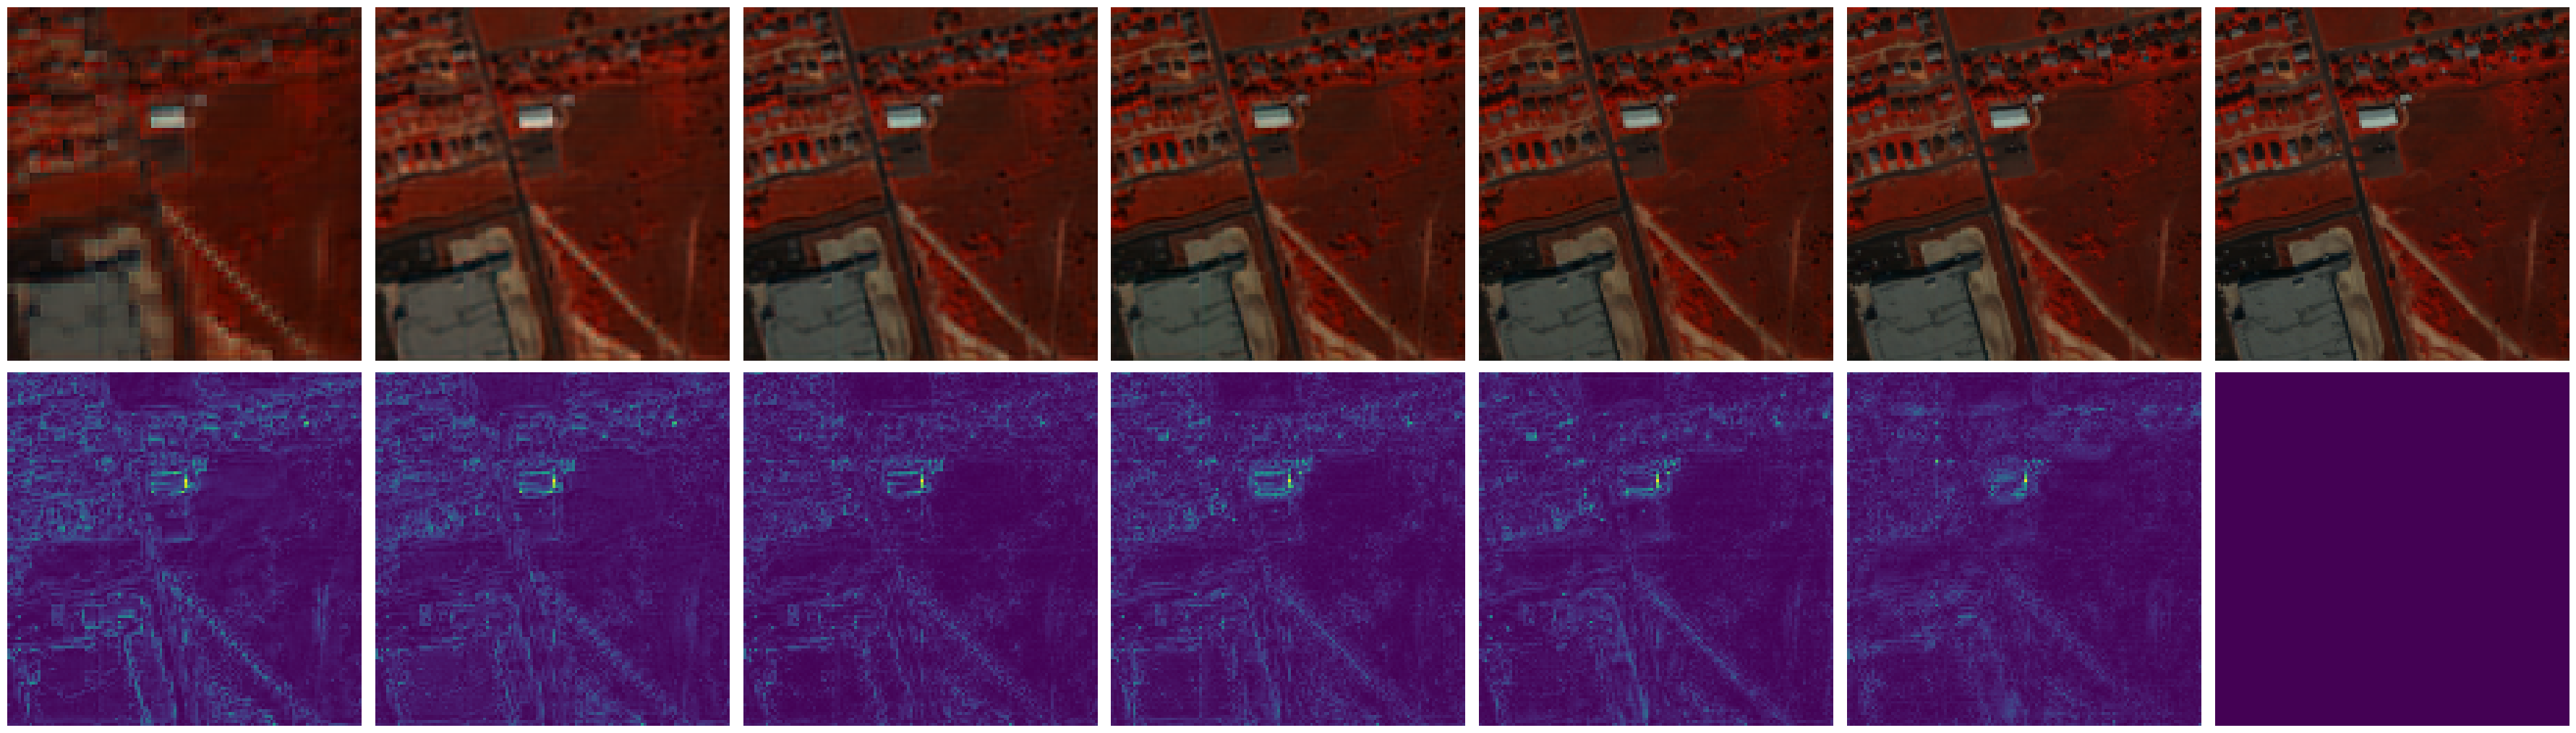

In [31]:
plt.figure(figsize=(7*512 / 100,2*512 / 100))
model_list = [
    '/wxw/lbs/SR/HSR/trained_modles/SGANet,Urban,2024-05-13,11:06:08/PSNR:20.9553.pth',
    '/wxw/lbs/SR/HSR/trained_modles/SGANet,Urban,2024-05-13,11:06:08/PSNR:23.6860.pth',
    '/wxw/lbs/SR/HSR/trained_modles/SGANet,Urban,2024-05-13,11:06:08/PSNR:26.3560.pth',
    '/wxw/lbs/SR/HSR/trained_modles/SGANet,Urban,2024-05-13,11:06:08/PSNR:28.6407.pth',
    '/wxw/lbs/SR/HSR/trained_modles/SGANet,Urban,2024-05-13,11:06:08/PSNR:30.9408.pth',
    '/wxw/lbs/SR/HSR/trained_modles/SGANet,Urban,2024-05-13,11:06:08/PSNR:36.1056.pth'
]
test_region = torch.tensor(test_region,dtype=torch.float32).cuda()
for loc in range(7):
    RGB_indexs = [10,60,100]
    band_index = [67-1,29-1,4-1]
    HRHSI = torch.zeros_like(test_region).cuda()
    if loc == 6:
        HRHSI = test_region
    else:
        model_path = model_list[loc]
        model = SGANet(162,64)
        model.load_state_dict(torch.load(model_path),
                              strict=False)
        model = model.cuda()
        model.eval()  
        with torch.no_grad():
            for i in range(0,128-64+1,32):
                for j in range(0,128-64+1,32):
                    tar_GT = test_region[:,i:i+64,j:j+64].cuda()
                    tar_RGB  = tar_GT[RGB_indexs]
                    tar_LRHSI = downSamlpe(tar_GT)
                    pre_HRHSI= model(tar_LRHSI.unsqueeze(0),tar_RGB.unsqueeze(0))
                    HRHSI[:,i:i+64,j:j+64] = pre_HRHSI.squeeze(0)
    erro_map = torch.mean(torch.abs((test_region[band_index].cuda() - HRHSI[band_index])),dim=0)
    print(erro_map.mean())
    plt.subplot(2,7,loc + 1)
    # plt.imshow(HRHSI[[25,10,0],:,:].permute(1,2,0).detach().cpu().numpy())
    plt.imshow(HRHSI[[67-1,29-1,4-1],:,:].permute(1,2,0).detach().cpu().numpy())
    plt.axis('off')
    plt.subplot(2,7,loc + 7 + 1)
    plt.imshow(erro_map.detach().cpu().numpy())
    plt.axis('off')
    plt.tight_layout()
plt.show()